# MDP with Dynamic Programming in PyTorch

We will evaluate and solve MDPs using dynamic programming (DP). It is worth to note that the Model-based methods such as DP have some drawbacks. They require the environment to be fully known, including the transition matrix and reward matrix. They also have limited scalability, especially for environments with plenty of states.

## Simple MDP

In [ ]:
import torch

Our MDP has 3 state (sleep, study and play games), and 2 actions (word, slack). The 3 * 2 * 3 transition matrix T(s, a, s') is as follows:

In [ ]:
T = torch.tensor([[[0.8, 0.1, 0.1],
                   [0.1, 0.6, 0.3]],
                  [[0.7, 0.2, 0.1],
                   [0.1, 0.8, 0.1]],
                  [[0.6, 0.2, 0.2],
                   [0.1, 0.4, 0.5]]]
                 )

This means, for example, that when taking the a1 slack action from state s0 study, there is a 60% chance that it will become s1 sleep (maybe getting tired ) and a 30% chance that it will become s2 play games (maybe wanting to relax ), and that there is a 10% chance of keeping on studying (maybe a true workaholic ).

In [ ]:
R = torch.tensor([1., 0, -1.])

gamma = 0.5

action = 0

We define the reward function as [+1, 0, -1] for three states, to compensate for the hard work. Obviously, the optimal policy, in this case, is choosing a0 work for each step (keep on studying – no pain no gain, right?). Also, we choose 0.5 as the discount factor, to begin with.

In this oversimplified study-sleep-game process, the optimal policy, that is, the policy that achieves the highest total reward, is choosing action a0 in all steps. However, it won't be that straightforward in most cases. Also, the actions taken in individual steps won't necessarily be the same. They are usually dependent on states. So, we will have to solve an MDP by finding the optimal policy in real-world cases.

The value function of a policy measures how good it is for an agent to be in each state, given the policy being followed. The greater the value, the better the state.

We calculate the value, V, of the optimal policy using the matrix inversion method in the following function:

In [ ]:
def cal_value_matrix_inversion(gamma, trans_matrix, rewards):
    inv = torch.inverse(torch.eye(rewards.shape[0]) - gamma * trans_matrix)
    V = torch.mm(inv, rewards.reshape(-1, 1))
    return V

Above, we calculated the value, V, of the optimal policy using matrix inversion. According to the Bellman Equation, the relationship between the value at step t+1 and that at step t can be expressed as follows:

$$V_{t+1} = R + \gamma*T*V_t$$

When the value converges, which means $V_{t+1} = V_t$, we can derive the value, $V$, as follows:

$$V = R + \gamma*T*V \\ V = (I-\gamma*T)^{-1}*R$$

Here, $I$ is the identity matrix with 1s on the main diagonal.

One advantage of solving an MDP with matrix inversion is that you always get an exact answer. But the downside is its scalability. As we need to compute the inversion of an m * m matrix (where m is the number of possible states), the computation will become costly if there is a large number of states.

We feed all variables we have to the function, including the transition probabilities associated with action a0:

In [ ]:
trans_matrix = T[:, action]
V = cal_value_matrix_inversion(gamma, trans_matrix, R)
print("The value function under the optimal policy is:\n{}".format(V))

The value function under the optimal policy is:
tensor([[ 1.6787],
        [ 0.6260],
        [-0.4820]])


We decide to experiment with different values for the discount factor. Let's start with 0, which means we only care about the immediate reward:

In [ ]:
gamma = 0
V = cal_value_matrix_inversion(gamma, trans_matrix, R)
print("The value function under the optimal policy is:\n{}".format(V))

The value function under the optimal policy is:
tensor([[ 1.],
        [ 0.],
        [-1.]])


This is consistent with the reward function as we only look at the reward received in the next move.

As the discount factor increases toward 1, future rewards are considered. Let's take a look at $\gamma$=0.99:

In [ ]:
gamma = 0.99
V = cal_value_matrix_inversion(gamma, trans_matrix, R)
print("The value function under the optimal policy is:\n{}".format(V))

The value function under the optimal policy is:
tensor([[65.8293],
        [64.7194],
        [63.4876]])


## Performing policy evaluation

Policy evaluation is an iterative algorithm. It starts with arbitrary policy values and then iteratively updates the values based on the Bellman expectation equation until they converge. In each iteration, the value of a policy, π, for a state, s, is updated as follows:

$$\mathcal{V}_{\pi}(s) = \sum_{a \in \mathcal{A}} \pi(a | s) (\mathcal{R}_s^a + \gamma \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^a {V}_{\pi}(s'))$$

There are two ways to terminate an iterative updating process. One is by setting a fixed number of iterations, such as 1,000 and 10,000, which might be difficult to control sometimes. Another one involves specifying a threshold (usually 0.0001, 0.00001, or something similar) and terminating the process only if the values of all states change to an extent that is lower than the threshold specified.

Next, we will perform policy evaluation on the study-sleep-game process under the optimal policy and a random policy.

In [ ]:
import torch

T = torch.tensor([[[0.8, 0.1, 0.1],
                   [0.1, 0.6, 0.3]],
                  [[0.7, 0.2, 0.1],
                   [0.1, 0.8, 0.1]],
                  [[0.6, 0.2, 0.2],
                   [0.1, 0.4, 0.5]]]
                 )

R = torch.tensor([1., 0, -1.])

gamma = .5

threshold = 0.0001

policy_optimal = torch.tensor([[1.0, 0.0],
                               [1.0, 0.0],
                               [1.0, 0.0]])

Develop a policy evaluation function that takes in a policy, transition matrix, rewards, discount factor, and a threshold and computes the value function:

In [ ]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, threshold):
    """
    Perform policy evaluation
    @param policy: policy matrix containing actions and their probability in each state
    @param trans_matrix: transformation matrix
    @param rewards: rewards for each state
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: values of the given policy for all possible states
    """
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state, actions in enumerate(policy):
            for action, action_prob in enumerate(actions):
                V_temp[state] += action_prob * (R[state] + gamma * torch.dot(trans_matrix[state, action], V))
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

The policy evaluation function does the following tasks:

- Initializes the policy values as all zeros.
- Updates the values based on the Bellman expectation equation.
- Computes the maximal change of the values across all states.
- If the maximal change is greater than the threshold, it keeps updating the values. Otherwise, it terminates the evaluation process and returns the latest values.

Now let's plug in the optimal policy and all other variables:

In [ ]:
V = policy_evaluation(policy_optimal, T, R, gamma, threshold)
print("The value function under the optimal policy is:\n{}".format(V))

The value function under the optimal policy is:
tensor([ 1.6786,  0.6260, -0.4821])


This is almost the same as what we got using matrix inversion.

We now experiment with another policy, a random policy where actions are picked with the same probabilities:

Plug in the random policy and all other variables:

In [ ]:
policy_random = torch.tensor([[0.5, 0.5],
                              [0.5, 0.5],
                              [0.5, 0.5]])

V = policy_evaluation(policy_random, T, R, gamma, threshold)
print("The value function under the random policy is:\n{}".format(V))

The value function under the random policy is:
tensor([ 1.2348,  0.2691, -0.9013])


We have just seen how effective it is to compute the value of a policy using policy evaluation. It is a simple convergent iterative approach, in the dynamic programming family, or to be more specific, approximate dynamic programming. It starts with random guesses as to the values and then iteratively updates them according to the Bellman expectation equation until they converge.

Since policy evaluation uses iterative approximation, its result might not be exactly the same as the result of the matrix inversion method, which uses exact computation. In fact, we don't really need the value function to be that precise. Also, it can solve the curses of dimensionality problem, which can result in scaling up the computation to thousands of millions of states. Therefore, we usually prefer policy evaluation over the other.

One more thing to remember is that policy evaluation is used to predict how great a we will get from a given policy; it is not used for control problems.

To take a closer look, we also plot the policy values over the whole evaluation process.

We first need to record the value for each iteration in the policy_evaluation function:

In [ ]:
def policy_evaluation_history(policy, trans_matrix, rewards, gamma, threshold):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    V_his = [V]
    i = 0
    while True:
        V_temp = torch.zeros(n_state)
        i += 1
        for state, actions in enumerate(policy):
            for action, action_prob in enumerate(actions):
                V_temp[state] += action_prob * (R[state] + gamma * torch.dot(trans_matrix[state, action], V))
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        V_his.append(V)
        if max_delta <= threshold:
            break
    return V, V_his

Now we feed the policy_evaluation_history function with the optimal policy, a discount factor of 0.5, and other variables:

In [ ]:
V, V_history = policy_evaluation_history(policy_optimal, T, R, gamma, threshold)

We then plot the resulting history of values using the following lines of code:

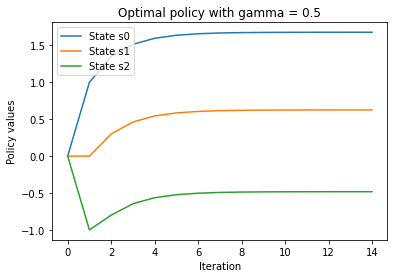

In [ ]:
import matplotlib.pyplot as plt
s0, = plt.plot([v[0] for v in V_history])
s1, = plt.plot([v[1] for v in V_history])
s2, = plt.plot([v[2] for v in V_history])
plt.title('Optimal policy with gamma = {}'.format(str(gamma)))
plt.xlabel('Iteration')
plt.ylabel('Policy values')
plt.legend([s0, s1, s2],
           ["State s0",
            "State s1",
            "State s2"], loc="upper left")
plt.show()

Next, we run the same code but with two different discount factors, 0.2 and 0.99.

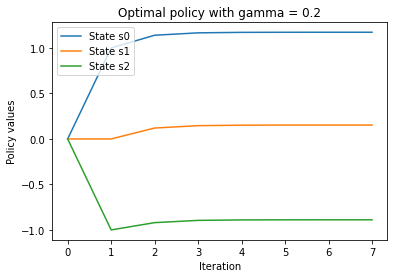

In [ ]:
gamma = 0.2
V, V_history = policy_evaluation_history(policy_optimal, T, R, gamma, threshold)

s0, = plt.plot([v[0] for v in V_history])
s1, = plt.plot([v[1] for v in V_history])
s2, = plt.plot([v[2] for v in V_history])
plt.title('Optimal policy with gamma = {}'.format(str(gamma)))
plt.xlabel('Iteration')
plt.ylabel('Policy values')
plt.legend([s0, s1, s2],
           ["State s0",
            "State s1",
            "State s2"], loc="upper left")
plt.show()

Comparing the plot with a discount factor of 0.5 with this one, we can see that the smaller the factor, the faster the policy values converge.

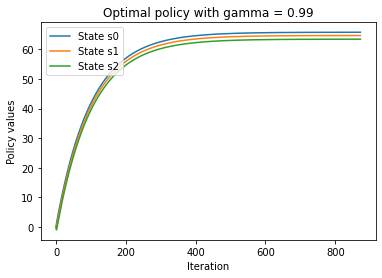

In [ ]:
gamma = 0.99
V, V_history = policy_evaluation_history(policy_optimal, T, R, gamma, threshold)

s0, = plt.plot([v[0] for v in V_history])
s1, = plt.plot([v[1] for v in V_history])
s2, = plt.plot([v[2] for v in V_history])
plt.title('Optimal policy with gamma = {}'.format(str(gamma)))
plt.xlabel('Iteration')
plt.ylabel('Policy values')
plt.legend([s0, s1, s2],
           ["State s0",
            "State s1",
            "State s2"], loc="upper left")
plt.show()

By comparing the plot with a discount factor of 0.5 to the plot with a discount factor of 0.99, we can see that the larger the factor, the longer it takes for policy values to converge. The discount factor is a tradeoff between rewards now and rewards in the future.

## Simulating the FrozenLake environment

The optimal policies for the MDPs we have dealt with so far are pretty intuitive. However, it won't be that straightforward in most cases, such as the FrozenLake environment.

FrozenLake is a typical Gym environment with a discrete state space. It is about moving an agent from the starting location to the goal location in a grid world, and at the same time avoiding traps. The grid is either four by four (https://gym.openai.com/envs/FrozenLake-v0/) or eight by eight.

The grid is made up of the following four types of tiles:

- S: The starting location
- G: The goal location, which terminates an episode
- F: The frozen tile, which is a walkable location
- H: The hole location, which terminates an episode

There are four actions, obviously: moving left (0), moving down (1), moving right (2), and moving up (3). The reward is +1 if the agent successfully reaches the goal location, and 0 otherwise. Also, the observation space is represented in a 16-dimensional integer array, and there are 4 possible actions (which makes sense).

What is tricky in this environment is that, as the ice surface is slippery, the agent won't always move in the direction it intends. For example, it may move to the left or to the right when it intends to move down.

In [ ]:
import gym
import torch


env = gym.make("FrozenLake-v0")

n_state = env.observation_space.n
print(n_state)
n_action = env.action_space.n
print(n_action)

16
4


In [ ]:
env.reset()

env.render()

new_state, reward, is_done, info = env.step(1)
env.render()


SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


In [ ]:
print(new_state)
print(reward)
print(is_done)
print(info)

4
0.0
False
{'prob': 0.3333333333333333}


To demonstrate how difficult it is to walk on the frozen lake, implement a random policy and calculate the average total reward over 1,000 episodes. First, define a function that simulates a FrozenLake episode given a policy and returns the total reward (we know it is either 0 or 1):

In [ ]:
def run_episode(env, policy):
    state = env.reset()
    total_reward = 0
    is_done = False
    while not is_done:
        action = policy[state].item()
        state, reward, is_done, info = env.step(action)
        total_reward += reward
        if is_done:
            break
    return total_reward

Now run 1000 episodes, and a policy will be randomly generated and will be used in each episode:

In [ ]:
n_episode = 1000

total_rewards = []
for episode in range(n_episode):
    random_policy = torch.randint(high=n_action, size=(n_state,))
    total_reward = run_episode(env, random_policy)
    total_rewards.append(total_reward)

print('Average total reward under random policy: {}'.format(sum(total_rewards) / n_episode))

Average total reward under random policy: 0.014


This basically means there is only a 1.4% chance on average that the agent can reach the goal if we randomize the actions.

Next, we experiment with a random search policy. In the training phase, we randomly generate a bunch of policies and record the first one that reaches the goal:

In [ ]:
while True:
    random_policy = torch.randint(high=n_action, size=(n_state,))
    total_reward = run_episode(env, random_policy)
    if total_reward == 1:
        best_policy = random_policy
        break

print(best_policy)

tensor([3, 3, 0, 3, 2, 0, 1, 3, 1, 2, 0, 1, 1, 1, 1, 0])


Now run 1,000 episodes with the policy we just cherry-picked:

In [ ]:
total_rewards = []
for episode in range(n_episode):
    total_reward = run_episode(env, best_policy)
    total_rewards.append(total_reward)

print('Average total reward under random search policy: {}'.format(sum(total_rewards) / n_episode))

Average total reward under random search policy: 0.111


Using the random search algorithm, the goal will be reached 11.1% of the time on average.

We can look into the details of the FrozenLake environment, including the transformation matrix and rewards for each state and action, by using the P attribute. For example, for state 6, we can do the following:

In [ ]:
print(env.env.P[6])

{0: [(0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 10, 0.0, False)], 1: [(0.3333333333333333, 5, 0.0, True), (0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 7, 0.0, True)], 2: [(0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 7, 0.0, True), (0.3333333333333333, 2, 0.0, False)], 3: [(0.3333333333333333, 7, 0.0, True), (0.3333333333333333, 2, 0.0, False), (0.3333333333333333, 5, 0.0, True)]}


This returns a dictionary with keys 0, 1, 2, and 3, representing four possible actions. The value is a list of movements after taking an action. The movement list is in the following format: (transformation probability, new state, reward received, is done). For instance, if the agent resides in state 6 and intends to take action 1 (down), there is a 33.33% chance that it will land in state 5, receiving a reward of 0 and terminating the episode; there is a 33.33% chance that it will land in state 10 and receive a reward of 0; and there is a 33.33% chance that it will land in state 7, receiving a reward of 0 and terminating the episode.

For state 11, we can do the following:

In [ ]:
print(env.env.P[11])

{0: [(1.0, 11, 0, True)], 1: [(1.0, 11, 0, True)], 2: [(1.0, 11, 0, True)], 3: [(1.0, 11, 0, True)]}


As stepping on a hole will terminate an episode, it won’t make any movement afterward.

Feel free to check out the other states.

## Solving an MDP with a value iteration algorithm

An MDP is considered solved if its optimal policy is found. In this recipe, we will figure out the optimal policy for the FrozenLake environment using a value iteration algorithm.

The idea behind value iteration is quite similar to that of policy evaluation. It is also an iterative algorithm. It starts with arbitrary policy values and then iteratively updates the values based on the Bellman optimality equation until they converge. So in each iteration, instead of taking the expectation (average) of values across all actions, it picks the action that achieves the maximal policy values:

$$\mathcal{V}_*(s) = \max_{a \in \mathcal{A}} (\mathcal{R}_s^a + \gamma \sum_{s' \in \mathcal{S}} \mathcal{P}_{ss'}^a {V}_{*}(s')))$$

Once the optimal values are computed, we can easily obtain the optimal policy accordingly.



In [ ]:
import torch
import gym

env = gym.make('FrozenLake-v0')

gamma = 0.99

threshold = 0.0001

Now define the function that computes optimal values based on the value iteration algorithm:

In [ ]:
def value_iteration(env, gamma, threshold):
    """
    Solve a given environment with value iteration algorithm
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: values of the optimal policy for the given environment
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.empty(n_state)
        for state in range(n_state):
            v_actions = torch.zeros(n_action)
            for action in range(n_action):
                for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                    v_actions[action] += trans_prob * (reward + gamma * V[new_state])
            V_temp[state] = torch.max(v_actions)
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

Plug in the environment, discount factor, and convergence threshold, then print the optimal values:

In [ ]:
V_optimal = value_iteration(env, gamma, threshold)
print('Optimal values:\n{}'.format(V_optimal))

Optimal values:
tensor([0.5404, 0.4966, 0.4681, 0.4541, 0.5569, 0.0000, 0.3572, 0.0000, 0.5905,
        0.6421, 0.6144, 0.0000, 0.0000, 0.7410, 0.8625, 0.0000])


Now that we have the optimal values, we develop the function that extracts the optimal policy out of them:

We developed our value_iteration function according to the Bellamn Optimality Equation. We perform the following tasks:

- Initialize the policy values as all zeros.
- Update the values based on the Bellman optimality equation.
- Compute the maximal change of the values across all states.
- If the maximal change is greater than the threshold, we keep updating the values. Otherwise, we terminate the evaluation process and return the latest values as the optimal values.

In [ ]:
def extract_optimal_policy(env, V_optimal, gamma):
    """
    Obtain the optimal policy based on the optimal values
    @param env: OpenAI Gym environment
    @param V_optimal: optimal values
    @param gamma: discount factor
    @return: optimal policy
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    optimal_policy = torch.zeros(n_state)
    for state in range(n_state):
        v_actions = torch.zeros(n_action)
        for action in range(n_action):
            for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                v_actions[action] += trans_prob * (reward + gamma * V_optimal[new_state])
        optimal_policy[state] = torch.argmax(v_actions)
    return optimal_policy

Plug in the environment, discount factor, and optimal values, then print the optimal policy:

In [ ]:
optimal_policy = extract_optimal_policy(env, V_optimal, gamma)
print('Optimal policy:\n{}'.format(optimal_policy))

Optimal policy:
tensor([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])


We want to gauge how good the optimal policy is. So, let's run 1,000 episodes with the optimal policy and check the average reward. Here, we will reuse the run_episode function we defined in the previous recipe:

In [ ]:
def run_episode(env, policy):
    state = env.reset()
    total_reward = 0
    is_done = False
    while not is_done:
        action = policy[state].item()
        state, reward, is_done, info = env.step(action)
        total_reward += reward
        if is_done:
            break
    return total_reward


n_episode = 1000
total_rewards = []
for episode in range(n_episode):
    total_reward = run_episode(env, optimal_policy)
    total_rewards.append(total_reward)

print('Average total reward under the optimal policy: {}'.format(sum(total_rewards) / n_episode))

Average total reward under the optimal policy: 0.737


Under the optimal policy, the agent will reach the goal 74% of the time, on average. This is the best we are able to get since the ice is slippery.

We obtained a success rate of 74% with a discount factor of 0.99. How does the discount factor affect the performance? Let's do some experiments with different factors, including 0, 0.2, 0.4, 0.6, 0.8, 0.99, and 1.:

In [ ]:
gammas = [0, 0.2, 0.4, 0.6, 0.8, .99, 1.]
n_episode = 10000
avg_reward_gamma = []
for gamma in gammas:
    V_optimal = value_iteration(env, gamma, threshold)
    optimal_policy = extract_optimal_policy(env, V_optimal, gamma)
    total_rewards = []
    for episode in range(n_episode):
        total_reward = run_episode(env, optimal_policy)
        total_rewards.append(total_reward)
    avg_reward_gamma.append(sum(total_rewards) / n_episode)

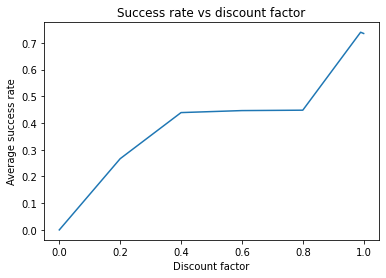

In [ ]:
import matplotlib.pyplot as plt
plt.plot(gammas, avg_reward_gamma)
plt.title('Success rate vs discount factor')
plt.xlabel('Discount factor')
plt.ylabel('Average success rate')
plt.show()

The result shows that the performance improves when there is an increase in the discount factor. This verifies the fact that a small discount factor values the reward now and a large discount factor values a better reward in the future.

## Solving an MDP with a policy iteration algorithm

Another approach to solving an MDP is by using a policy iteration algorithm, which we will discuss in this section.

A policy iteration algorithm can be subdivided into two components: policy evaluation and policy improvement. It starts with an arbitrary policy. And in each iteration, it first computes the policy values given the latest policy, based on the Bellman expectation equation; it then extracts an improved policy out of the resulting policy values, based on the Bellman optimality equation. It iteratively evaluates the policy and generates an improved version until the policy doesn't change any more.

Let's develop a policy iteration algorithm and use it to solve the FrozenLake environment.

In [ ]:
import torch
import gym

env = gym.make('FrozenLake-v0')

gamma = 0.99

threshold = 0.0001

Now we define the policy_evaluation function that computes the values given a policy:

In [ ]:
def policy_evaluation(env, policy, gamma, threshold):
    """
    Perform policy evaluation
    @param env: OpenAI Gym environment
    @param policy: policy matrix containing actions and their probability in each state
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: values of the given policy
    """
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(n_state):
            action = policy[state].item()
            for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                V_temp[state] += trans_prob * (reward + gamma * V[new_state])
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

Next, we develop the second main component of the policy iteration algorithm, the policy improvement part:

In [ ]:
def policy_improvement(env, V, gamma):
    """
    Obtain an improved policy based on the values
    @param env: OpenAI Gym environment
    @param V: policy values
    @param gamma: discount factor
    @return: the policy
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    policy = torch.zeros(n_state)
    for state in range(n_state):
        v_actions = torch.zeros(n_action)
        for action in range(n_action):
            for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                v_actions[action] += trans_prob * (reward + gamma * V[new_state])
        policy[state] = torch.argmax(v_actions)
    return policy

This extracts an improved policy from the given policy values, based on the Bellman optimality equation.

Now that we have both components ready, we develop the policy iteration algorithm as follows:

In [ ]:
def policy_iteration(env, gamma, threshold):
    """
    Solve a given environment with policy iteration algorithm
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: optimal values and the optimal policy for the given environment
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    policy = torch.randint(high=n_action, size=(n_state,)).float()
    while True:
        V = policy_evaluation(env, policy, gamma, threshold)
        policy_improved = policy_improvement(env, V, gamma)
        if torch.equal(policy_improved, policy):
            return V, policy_improved
        policy = policy_improved

The policy_iteration function does the following tasks:

- Initializes a random policy.
- Computes the values of the policy with the policy evaluation algorithm.
- Obtains an improved policy based on the policy values.
- If the new policy is different from the old one, it updates the policy and runs another iteration. Otherwise, it terminates the iteration process and returns the policy values and the policy.

Plug in the environment, discount factor, and convergence threshold:

In [ ]:
V_optimal, optimal_policy = policy_iteration(env, gamma, threshold)
print('Optimal values:\n{}'.format(V_optimal))
print('Optimal policy:\n{}'.format(optimal_policy))

Optimal values:
tensor([0.5404, 0.4966, 0.4681, 0.4541, 0.5569, 0.0000, 0.3572, 0.0000, 0.5905,
        0.6421, 0.6144, 0.0000, 0.0000, 0.7410, 0.8625, 0.0000])
Optimal policy:
tensor([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])


They are exactly the same as what we got using the value iteration algorithm.

We have just solved the FrozenLake environment with a policy iteration algorithm. So, you may wonder when it is better to use policy iteration over value iteration and vice versa. There are basically three scenarios where one has the edge over the other:

- If there is a large number of actions, use policy iteration, as it can converge faster.
- If there is a small number of actions, use value iteration.
- If there is already a viable policy (obtained either by intuition or domain knowledge), use policy iteration.

Outside those scenarios, policy iteration and value iteration are generally comparable.

In the next section, we will apply each algorithm to solve the coin-flipping-gamble problem. We will see which algorithm converges faster.

## Solving the coin-flipping gamble problem
Gambling on coin flipping should sound familiar to everyone. In each round of the game, the gambler can make a bet on whether a coin flip will show heads. If it turns out heads, the gambler will win the same amount they bet; otherwise, they will lose this amount. The game continues until the gambler loses (ends up with nothing) or wins (wins more than 100 dollars, let's say). Let's say the coin is unfair and it lands on heads 40% of the time. In order to maximize the chance of winning, how much should the gambler bet based on their current capital in each round? This will definitely be an interesting problem to solve.

If the coin lands on heads more than 50% of the time, there is nothing to discuss. The gambler can just keep betting one dollar each round and should win the game most of the time. If it is a fair coin, the gambler could bet one dollar each round and end up winning around 50% of the time. It gets tricky when the probability of heads is lower than 50%; the safe-bet strategy wouldn't work anymore. Nor would a random strategy, either. We need to resort to the reinforcement learning techniques we've learned in this tutorial to make smart bets.

Let's get started by formulating the coin-flipping gamble problem as an MDP. It is basically an undiscounted, episodic, and finite MDP with the following properties:

- The state is the gambler's capital in dollars. There are 101 states: 0, 1, 2, …, 98, 99, and 100+.
- The reward is 1 if the state 100+ is reached; otherwise, the reward is 0.
- The action is the possible amount the gambler bets in a round. Given state s, the possible actions include 1, 2, …, and min(s, 100 - s). For example, when the gambler has 60 dollars, they can bet any amount from 1 to 40. Any amount above 40 doesn't make any sense as it increases the loss and doesn't increase the chance of winning.
- The next state after taking an action depends on the probability of the coin coming up heads. Let's say it is 40%. So, the next state of state s after taking action a will be s+a by 40%, s-a by 60%.
- The process terminates at state 0 and state 100+.

In [ ]:
import torch

capital_max = 100
n_state = capital_max + 1
rewards = torch.zeros(n_state)
rewards[-1] = 1

print(rewards)

gamma = 1
threshold = 1e-10

head_prob = 0.4

env = {'capital_max': capital_max,
       'head_prob': head_prob,
       'rewards': rewards,
       'n_state': n_state}

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


Now we develop a function that computes optimal values based on the value iteration algorithm:

In [ ]:
def value_iteration(env, gamma, threshold):
    """
    Solve the coin flipping gamble problem with value iteration algorithm
    @param env: the coin flipping gamble environment
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: values of the optimal policy for the given environment
    """
    head_prob = env['head_prob']
    n_state = env['n_state']
    capital_max = env['capital_max']
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(1, capital_max):
            v_actions = torch.zeros(min(state, capital_max - state) + 1)
            for action in range(1, min(state, capital_max - state) + 1):
                v_actions[action] += head_prob * (rewards[state + action] + gamma * V[state + action])
                v_actions[action] += (1 - head_prob) * (rewards[state - action] + gamma * V[state - action])
            V_temp[state] = torch.max(v_actions)
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

We only need to compute the values for states 1 to 99, as the values for state 0 and state 100+ are 0. And given state s, the possible actions can be anything from 1 up to min(s, 100 - s). We should keep this in mind while computing the Bellman optimality equation.

Next, we develop a function that extracts the optimal policy based on the optimal values:

In [ ]:
def extract_optimal_policy(env, V_optimal, gamma):
    """
    Obtain the optimal policy based on the optimal values
    @param env: the coin flipping gamble environment
    @param V_optimal: optimal values
    @param gamma: discount factor
    @return: optimal policy
    """
    head_prob = env['head_prob']
    n_state = env['n_state']
    capital_max = env['capital_max']
    optimal_policy = torch.zeros(capital_max).int()
    for state in range(1, capital_max):
        v_actions = torch.zeros(n_state)
        for action in range(1, min(state, capital_max - state) + 1):
            v_actions[action] += head_prob * (rewards[state + action] + gamma * V_optimal[state + action])
            v_actions[action] += (1 - head_prob) * (rewards[state - action] + gamma * V_optimal[state - action])
        optimal_policy[state] = torch.argmax(v_actions)
    return optimal_policy

Finally, we can plug in the environment, discount factor, and convergence threshold to compute the optimal values and optimal policy after . Also, we time how long it takes to solve the gamble MDP with value iteration; we will compare this with the time it takes for policy iteration to complete:

In [ ]:
import time

start_time = time.time()
V_optimal = value_iteration(env, gamma, threshold)
optimal_policy = extract_optimal_policy(env, V_optimal, gamma)

print("It takes {:.3f}s to solve with value iteration".format(time.time() - start_time))

It takes 3.126s to solve with value iteration


We solved the gamble problem with value iteration in 3.126 seconds.

Take a look at the optimal policy values and the optimal policy we got:

In [ ]:
print('Optimal values:\n{}'.format(V_optimal))
print('Optimal policy:\n{}'.format(optimal_policy))

Optimal values:
tensor([0.0000, 0.0021, 0.0052, 0.0092, 0.0129, 0.0174, 0.0231, 0.0278, 0.0323,
        0.0377, 0.0435, 0.0504, 0.0577, 0.0652, 0.0695, 0.0744, 0.0807, 0.0866,
        0.0942, 0.1031, 0.1087, 0.1160, 0.1259, 0.1336, 0.1441, 0.1600, 0.1631,
        0.1677, 0.1738, 0.1794, 0.1861, 0.1946, 0.2017, 0.2084, 0.2165, 0.2252,
        0.2355, 0.2465, 0.2579, 0.2643, 0.2716, 0.2810, 0.2899, 0.3013, 0.3147,
        0.3230, 0.3339, 0.3488, 0.3604, 0.3762, 0.4000, 0.4031, 0.4077, 0.4138,
        0.4194, 0.4261, 0.4346, 0.4417, 0.4484, 0.4565, 0.4652, 0.4755, 0.4865,
        0.4979, 0.5043, 0.5116, 0.5210, 0.5299, 0.5413, 0.5547, 0.5630, 0.5740,
        0.5888, 0.6004, 0.6162, 0.6400, 0.6446, 0.6516, 0.6608, 0.6690, 0.6791,
        0.6919, 0.7026, 0.7126, 0.7248, 0.7378, 0.7533, 0.7697, 0.7868, 0.7965,
        0.8075, 0.8215, 0.8349, 0.8520, 0.8721, 0.8845, 0.9009, 0.9232, 0.9406,
        0.9643, 0.0000])
Optimal policy:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,

We can plot the policy value versus state as follows:

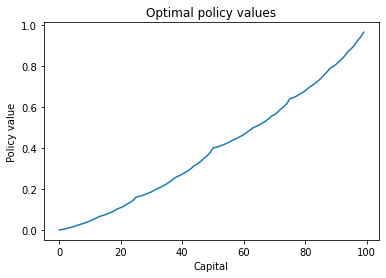

In [ ]:
import matplotlib.pyplot as plt

plt.plot(V_optimal[:100].numpy())
plt.title('Optimal policy values')
plt.xlabel('Capital')
plt.ylabel('Policy value')
plt.show()

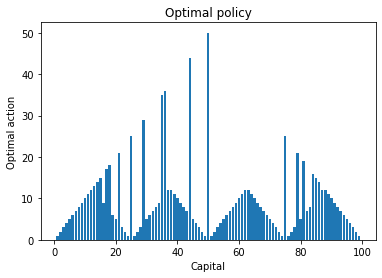

In [ ]:
plt.bar(range(1, capital_max), optimal_policy[1:capital_max].numpy())
plt.title('Optimal policy')
plt.xlabel('Capital')
plt.ylabel('Optimal action')
plt.show()

Now that we've solved the gamble problem with value iteration, how about policy iteration? Let's see.

We start by developing the policy_evaluation function that computes the values given a policy:

In [ ]:
def policy_evaluation(env, policy, gamma, threshold):
    """
    Perform policy evaluation
    @param env: the coin flipping gamble environment
    @param policy: policy tensor containing actions taken for individual state
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: values of the given policy
    """
    head_prob = env['head_prob']
    n_state = env['n_state']
    capital_max = env['capital_max']
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(1, capital_max):
            action = policy[state].item()
            V_temp[state] += head_prob * (rewards[state + action] + gamma * V[state + action])
            V_temp[state] += (1 - head_prob) * (rewards[state - action] + gamma * V[state - action])
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

Next, we develop another main component of the policy iteration algorithm, the policy improvement part:

In [ ]:
def policy_improvement(env, V, gamma):
    """
    Obtain an improved policy based on the values
    @param env: the coin flipping gamble environment
    @param V: policy values
    @param gamma: discount factor
    @return: the policy
    """
    head_prob = env['head_prob']
    n_state = env['n_state']
    capital_max = env['capital_max']
    policy = torch.zeros(n_state).int()
    for state in range(1, capital_max):
        v_actions = torch.zeros(min(state, capital_max - state) + 1)
        for action in range(1, min(state, capital_max - state) + 1):
            v_actions[action] += head_prob * (rewards[state + action] + gamma * V[state + action])
            v_actions[action] += (1 - head_prob) * (rewards[state - action] + gamma * V[state - action])
        policy[state] = torch.argmax(v_actions)
    return policy

With both components ready, we can develop the main entry to the policy iteration algorithm as follows:

In [ ]:
def policy_iteration(env, gamma, threshold):
    """
    Solve the coin flipping gamble problem with policy iteration algorithm
    @param env: the coin flipping gamble environment
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: optimal values and the optimal policy for the given environment
    """
    n_state = env['n_state']
    policy = torch.zeros(n_state).int()
    while True:
        V = policy_evaluation(env, policy, gamma, threshold)
        policy_improved = policy_improvement(env, V, gamma)
        if torch.equal(policy_improved, policy):
            return V, policy_improved
        policy = policy_improved

Finally, we plug in the environment, discount factor, and convergence threshold to compute the optimal values and the optimal policy. We record the time spent solving the MDP as well:

In [ ]:
start_time = time.time()
V_optimal, optimal_policy = policy_iteration(env, gamma, threshold)

print("It takes {:.3f}s to solve with policy iteration".format(time.time() - start_time))

It takes 2.951s to solve with policy iteration


Check out the optimal values and optimal policy we just obtained:

In [ ]:
print('Optimal values:\n{}'.format(V_optimal))
print('Optimal policy:\n{}'.format(optimal_policy))

Optimal values:
tensor([0.0000, 0.0021, 0.0052, 0.0092, 0.0129, 0.0174, 0.0231, 0.0278, 0.0323,
        0.0377, 0.0435, 0.0504, 0.0577, 0.0652, 0.0695, 0.0744, 0.0807, 0.0866,
        0.0942, 0.1031, 0.1087, 0.1160, 0.1259, 0.1336, 0.1441, 0.1600, 0.1631,
        0.1677, 0.1738, 0.1794, 0.1861, 0.1946, 0.2017, 0.2084, 0.2165, 0.2252,
        0.2355, 0.2465, 0.2579, 0.2643, 0.2716, 0.2810, 0.2899, 0.3013, 0.3147,
        0.3230, 0.3339, 0.3488, 0.3604, 0.3762, 0.4000, 0.4031, 0.4077, 0.4138,
        0.4194, 0.4261, 0.4346, 0.4417, 0.4484, 0.4565, 0.4652, 0.4755, 0.4865,
        0.4979, 0.5043, 0.5116, 0.5210, 0.5299, 0.5413, 0.5547, 0.5630, 0.5740,
        0.5888, 0.6004, 0.6162, 0.6400, 0.6446, 0.6516, 0.6608, 0.6690, 0.6791,
        0.6919, 0.7026, 0.7126, 0.7248, 0.7378, 0.7533, 0.7697, 0.7868, 0.7965,
        0.8075, 0.8215, 0.8349, 0.8520, 0.8721, 0.8845, 0.9009, 0.9232, 0.9406,
        0.9643, 0.0000])
Optimal policy:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,

The results from the two approaches, value iteration and policy iteration, are consistent.

We have solved the gamble problem by using value iteration and policy iteration. To deal with a reinforcement learning problem, one of the trickiest tasks is to formulate the process into an MDP. In our case, the policy is transformed from the current capital (states) to the new capital (new states) by betting certain stakes (actions). The optimal policy maximizes the probability of winning the game (+1 reward), and evaluates the probability of winning under the optimal policy.

Another interesting thing to note is how the transformation probabilities and new states are determined in the Bellman equation in our example. Taking action a in state s (having capital s and making a bet of 1 dollar) will have two possible outcomes:

- Moving to new state s+a, if the coin lands on heads. Hence, the transformation probability is equal to the probability of heads.
- Moving to new state s-a, if the coin lands on tails. Therefore, the transformation probability is equal to the probability of tails.
This is quite similar to the FrozenLake environment, where the agent lands on the intended tile only by a certain probability.

We also verified that policy iteration converges faster than value iteration in this case. This is because there are up to 50 possible actions, which is more than the 4 actions in FrozenLake. For MDPs with a large number of actions, solving with policy iteration is more efficient than doing so with value iteration.

You may want to know whether the optimal policy really works. Let's act like smart gamblers and play 10,000 episodes of the game. We are going to compare the optimal policy with two other strategies: conservative (betting one dollar each round) and random (betting a random amount):

In [ ]:
def run_random_episode(head, capital):
    while capital > 0:
        # print(capital)
        # bet = torch.randint(1, capital + 1, (1,)).item()
        bet = 1
        if torch.rand(1).item() < head:
            capital += bet
            if capital >= 100:
                return 1
        else:
            capital -= bet
    return 0


def run_optimal_episode(head, capital, optimal_policy):
    while capital > 0:
        bet = optimal_policy[capital].item()
        if torch.rand(1).item() < head:
            capital += bet
            if capital >= 100:
                return 1
        else:
            capital -= bet
    return 0


capital = 50

n_episode = 5000
total_rewards_random = []
total_rewards_opt = []

for episode in range(n_episode):
    total_reward_random = run_random_episode(0.48, capital)
    total_reward_opt = run_optimal_episode(0.4, capital, optimal_policy)
    total_rewards_random.append(total_reward_random)
    total_rewards_opt.append(total_reward_opt)

In [ ]:
print('Average total reward under the random policy: {}'.format(sum(total_rewards_random) / n_episode))
print('Average total reward under the optimal policy: {}'.format(sum(total_rewards_opt) / n_episode))

Average total reward under the random policy: 0.0152
Average total reward under the optimal policy: 0.4014


Our optimal policy is clearly the winner!